In [1]:
import torch
import torch.nn as nn
import torchvision

import numpy as np
from PIL import Image
from tqdm import tqdm
from livelossplot import PlotLosses

from sklearn.metrics import classification_report, f1_score
%pylab inline
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
from sklearn.utils import class_weight

Using TensorFlow backend.


Populating the interactive namespace from numpy and matplotlib


In [2]:
# Change path to root folder of the data provided
path_to_data = 'data/'

# a dataset abstraction that figures out classes on it's own based on what folder the images were in
_data = torchvision.datasets.DatasetFolder(
    path_to_data,                                  # root path, it'll get paths to actual images on it's own
    Image.open,                                    # pillow open image function to load data from given path
    ['jpg', 'JPG'],                                # list of extensions for images in dataset
    transform = torchvision.transforms.Compose([   # a pipeline of transformations to apply on the read image
        torchvision.transforms.RandomChoice([
            torchvision.transforms.RandomResizedCrop(224, scale=(0.7, 1.0)),
            torchvision.transforms.Resize((224, 224))
        ]),
#         torchvision.transforms.RandomApply([
            torchvision.transforms.RandomHorizontalFlip(),
            torchvision.transforms.RandomVerticalFlip(),
            torchvision.transforms.ColorJitter(
                brightness=0.7,
                contrast=0.7,
                saturation=0.7,
                hue=0.3),
            torchvision.transforms.RandomRotation(15),
#         ]),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], # the documentation said that alexnet was modelled with
                                 std=[0.229, 0.224, 0.225]),         # images using this normalisation parameters
    ]),
)

In [3]:
# some unfortunate ugly code to split the data randomly into training and testing
split_at = 0.7
train, test = torch.utils.data.random_split(
    _data,
    [int(split_at*(len(_data))), len(_data) - int(split_at*(len(_data)))]
)

In [4]:
batch_size = 96
# defining loaders for the train and test datasets
train_batches = torch.utils.data.DataLoader(
    train,                                       # dataset 
    batch_size=batch_size,                       # size of batches to load
    shuffle=True,
    num_workers=8,                               # no of workers
    pin_memory=True                              # Host to GPU copies are much faster when they originate from pinned (page-locked) memory. CPU tensors and storages expose a pin_memory() method, that returns a copy of the object, with data put in a pinned region.
) 

test_batches = torch.utils.data.DataLoader(
    test,                                       # dataset 
    batch_size=batch_size,                      # size of batches to load
    shuffle=True,
    num_workers=8,                               # no of workers
    pin_memory=True                              # Host to GPU copies are much faster when they originate from pinned (page-locked) memory. CPU tensors and storages expose a pin_memory() method, that returns a copy of the object, with data put in a pinned region.
) 

In [5]:
# it'll download alexnet weights on it's own
squeezenet = torchvision.models.squeezenet1_1(
    pretrained=True,
)
squeezenet

c:\users\dhruv\appdata\local\programs\python\python36\lib\site-packages\torchvision\models\squeezenet.py:94: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
  init.kaiming_uniform(m.weight.data)
c:\users\dhruv\appdata\local\programs\python\python36\lib\site-packages\torchvision\models\squeezenet.py:92: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  init.normal(m.weight.data, mean=0.0, std=0.01)


SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace)
    )
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0

In [6]:
# get list of classes from names of folders inside the path to data
import os
label_names = os.listdir(path_to_data)

# set num of classes, so as to set the output dimensions
squeezenet.num_classes = len(label_names)

In [7]:
# create new instances of the same layers, to get rid of the pretrained weights in the classification layers
# we want to learn our own
layers = [
#     nn.BatchNorm2d(512),
    nn.Dropout(0.5),
    nn.Conv2d(512, squeezenet.num_classes, kernel_size=(1, 1), stride=(1, 1)),
#     nn.BatchNorm2d(squeezenet.num_classes),
    nn.ReLU(inplace=True),
#     nn.Dropout(0.5),
    nn.AvgPool2d(kernel_size=13, stride=1, padding=0)
]

# change the classification layers to the untrained ones we just defined
# I am not sure why this syntax works, I found it in a medium article
squeezenet.classifier = nn.Sequential(*layers)
# but it gets the job done
squeezenet.classifier

Sequential(
  (0): Dropout(p=0.5)
  (1): Conv2d(512, 8, kernel_size=(1, 1), stride=(1, 1))
  (2): ReLU(inplace)
  (3): AvgPool2d(kernel_size=13, stride=1, padding=0)
)

In [22]:
loss = nn.CrossEntropyLoss(
    weight = torch.tensor([0.66704036, 1.2192623 , 1.44417476, 1.17125984, 1.31637168,
       1.04020979, 1.35227273, 0.59738956]).half().to(device)
)                # loss function
# it's softmax followed by Negative Log Likelihood loss

# defining an optimizer
optimizer = torch.optim.Adam(
    squeezenet.parameters(),   
    lr=1e-4,
    amsgrad = True
)

squeezenet.to(device)           # load up all the weights to cuda device memory, if available
live_losses = PlotLosses()   # a tool for drawing plots

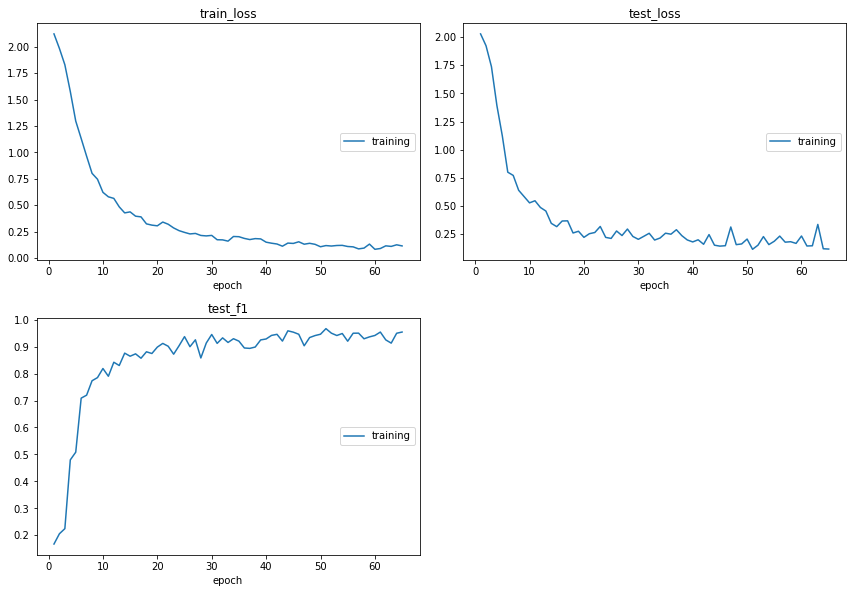

In [9]:
# training
for epoch in range(65):
    squeezenet.train()  # set model to train mode. not sure what that does, probably some optimisations
    
    train_errors = []  
    test_errors = []
    for batch in (tqdm(train_batches)):
        X, Y = batch
        pred = squeezenet(X.to(device))
        
        optimizer.zero_grad()               # reset the gradients
        error = loss(pred, Y.to(device))    # get loss
        error.backward()                    # propogate loss backwards
        optimizer.step()                    # update params
        
        train_errors.append(error.data.item())
        
    
    squeezenet.eval()  # set model to evaluate mode. not sure what that does exactly
    
    # some code to calculate f1 score for the test set
    predict = lambda x: torch.argmax(x, dim=1).cpu().numpy()
    test_predictions = []
    test_actual = []
    for batch in test_batches:
        x, y = batch
        pred = squeezenet(x.to(device))
        test_predictions.append(predict(pred))
        test_errors.append(loss(pred, y.to(device)).data.item())    # get loss
        test_actual.append(np.array(y))
    
#     train_predictions = []
#     train_actual = []
#     for batch in train_batches:
#         x, y = batch
#         pred = squeezenet(x.to(device))
#         train_predictions.append(predict(pred))
#         train_actual.append(np.array(y))

    # log data to be plotted later
    live_losses.update({
        'train_loss': np.mean(np.array(train_errors)),
        'test_loss': np.mean(np.array(test_errors)),
#         'train_f1': f1_score(np.concatenate(train_actual), np.concatenate(train_predictions), average='weighted'),
        'test_f1': f1_score(np.concatenate(test_actual), np.concatenate(test_predictions), average='weighted'),
    })
    live_losses.draw() # plot loss curves   



In [10]:
# print(classification_report(
#     np.concatenate(train_actual),
#     np.concatenate(train_predictions),
#     labels = range(len(label_names)),
#     target_names = label_names
# ))


print(classification_report(
    np.concatenate(test_actual),
    np.concatenate(test_predictions),
    labels = range(len(label_names)),
    target_names = label_names
))

                                  precision    recall  f1-score   support

FEIT_40W_T8_TUBE_MCRWV_BULB_120V       0.92      0.96      0.94        46
  GE_60W_LED_A19_FROST_5000K_8CT       0.94      0.97      0.95        30
 GE_Appliance_LED_40W_Warm_White       1.00      0.95      0.97        19
     GE_Basic_LED_60W_Soft_Light       1.00      0.95      0.98        22
       GE_Basic_LED_90W_Daylight       1.00      0.96      0.98        24
   GE_Classic_LED_65W_Soft_White       0.93      1.00      0.97        28
   GE_Vintage_LED_60W_Warm_Light       0.91      1.00      0.95        20
 OSI_60W_13W_CFL_SOFT_WHITE_6_CT       0.98      0.90      0.94        49

                       micro avg       0.95      0.95      0.95       238
                       macro avg       0.96      0.96      0.96       238
                    weighted avg       0.96      0.95      0.95       238



In [24]:
torch.save({
'state_dict': squeezenet.state_dict(),
}, "squeeznet_half")

In [12]:
# x = batch[0]
# y = batch[1]
# alexnet(x)
torch.cuda.memory_allocated()

943195136

In [13]:
squeezenet

SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace)
    )
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0

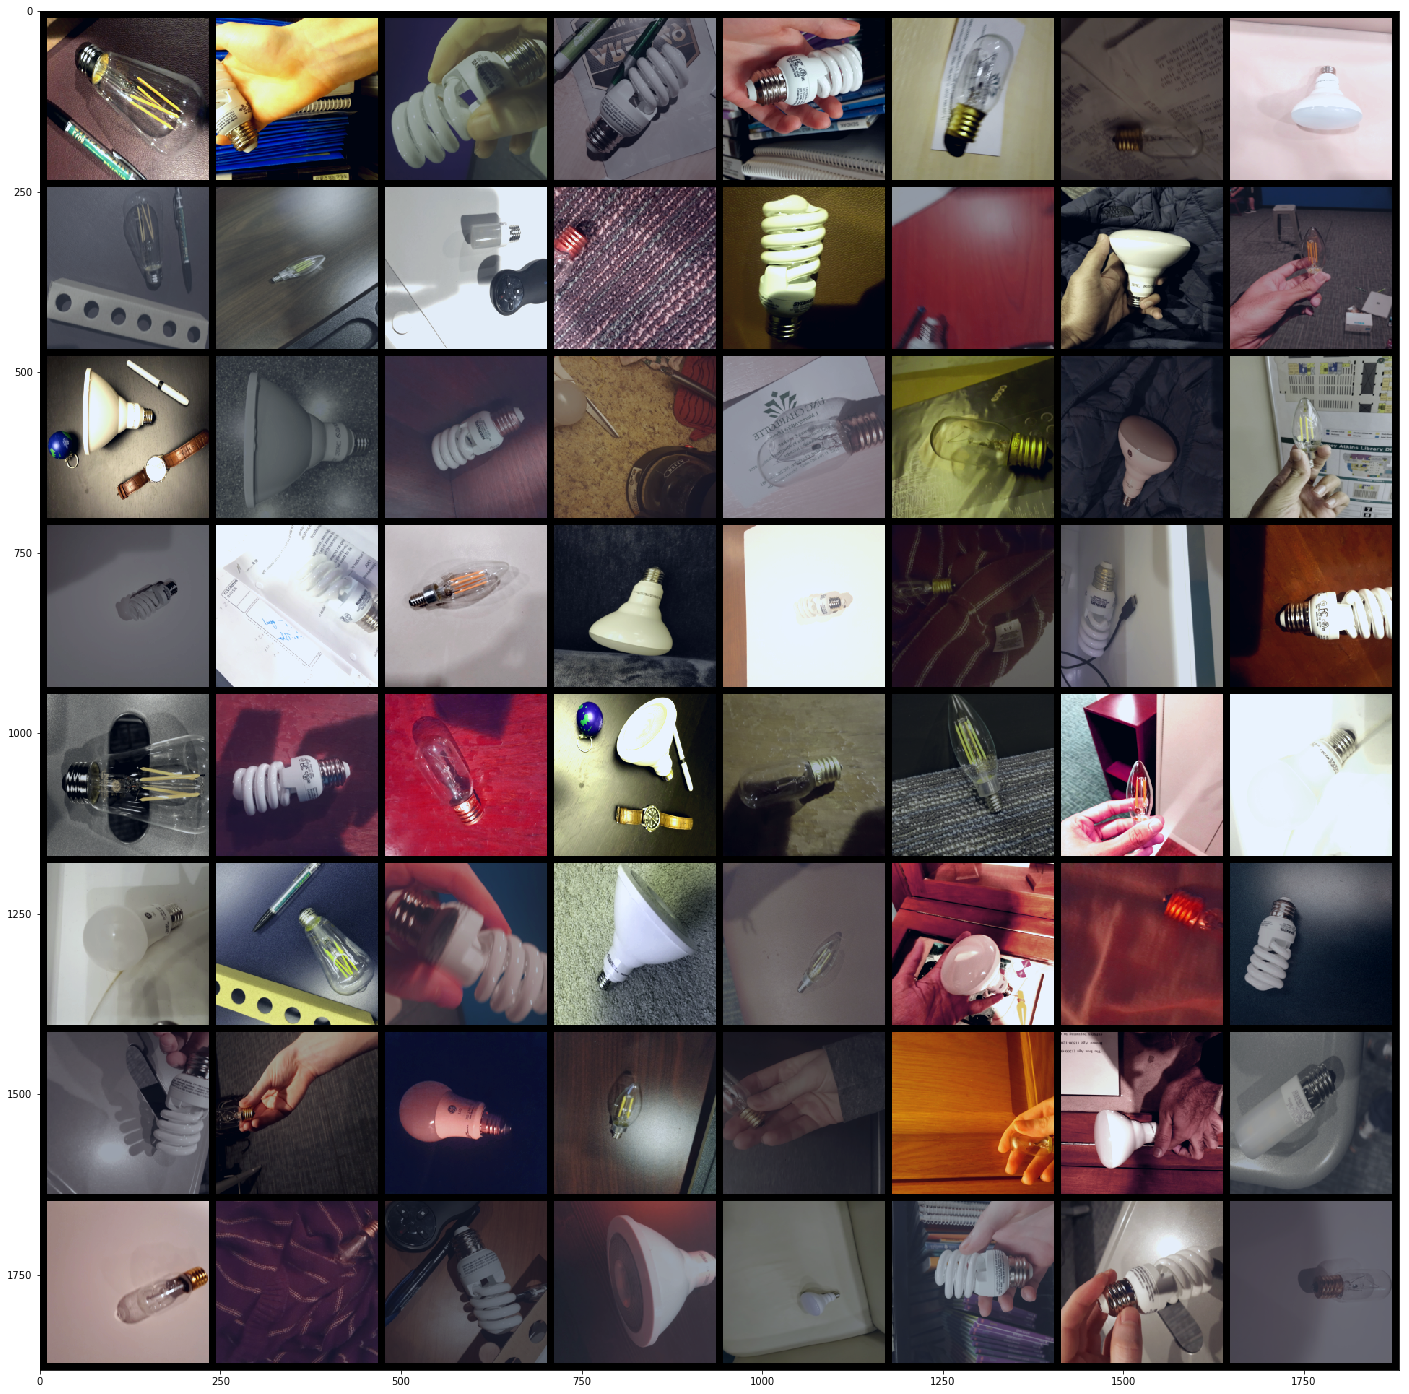

In [17]:
x, y = next(batches)
%matplotlib inline
def show(img):
    plt.figure(figsize=(25,25))
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    
show(torchvision.utils.make_grid(x, padding=10, normalize=True))

In [6]:
batches = iter(train_batches)

In [4]:
import time

%matplotlib inline
i = 0
for batch in train_batches:
    x, y = batch
    plt.figure(figsize=(25,25))
    npimg = torchvision.utils.make_grid(x, padding=10, normalize=True).numpy()
    plt.imsave(str(i)+".jpg", np.transpose(npimg, (1,2,0)))
    i = i + 1


c:\users\dhruv\appdata\local\programs\python\python36\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<Figure size 1800x1800 with 0 Axes>

<Figure size 1800x1800 with 0 Axes>

<Figure size 1800x1800 with 0 Axes>

<Figure size 1800x1800 with 0 Axes>

<Figure size 1800x1800 with 0 Axes>

<Figure size 1800x1800 with 0 Axes>

<Figure size 1800x1800 with 0 Axes>

<Figure size 1800x1800 with 0 Axes>

<Figure size 1800x1800 with 0 Axes>

<Figure size 1800x1800 with 0 Axes>

<Figure size 1800x1800 with 0 Axes>

<Figure size 1800x1800 with 0 Axes>

<Figure size 1800x1800 with 0 Axes>

<Figure size 1800x1800 with 0 Axes>

<Figure size 1800x1800 with 0 Axes>

<Figure size 1800x1800 with 0 Axes>

<Figure size 1800x1800 with 0 Axes>

<Figure size 1800x1800 with 0 Axes>

<Figure size 1800x1800 with 0 Axes>

<Figure size 1800x1800 with 0 Axes>

<Figure size 1800x1800 with 0 Axes>

<Figure size 1800x1800 with 0 Axes>

<Figure size 1800x1800 with 0 Axes>

<Figure size 1800x1800 with 0 Axes>

<Figure size 1800x1800 with 0 Axes>

<Figure size 1800x1800 with 0 Axes>

<Figure size 1800x1800 with 0 Axes>

<Figure size 1800x1800 with 0 Axes>

<Figure size 1800x1800 with 0 Axes>

<Figure size 1800x1800 with 0 Axes>

<Figure size 1800x1800 with 0 Axes>

<Figure size 1800x1800 with 0 Axes>

<Figure size 1800x1800 with 0 Axes>

<Figure size 1800x1800 with 0 Axes>

<Figure size 1800x1800 with 0 Axes>

<Figure size 1800x1800 with 0 Axes>

<Figure size 1800x1800 with 0 Axes>

<Figure size 1800x1800 with 0 Axes>

In [23]:
squeezenet.eval()
predict = lambda x: torch.argmax(x, dim=1).cpu().numpy()
test_predictions = []
test_actual = []
for batch in train_batches:
    x, y = batch
    pred = squeezenet(x.half().to(device))
    test_predictions.append(predict(pred))
    test_errors.append(loss(pred, y.to(device)).data.item())    # get loss
    test_actual.append(np.array(y))

print(classification_report(
    np.concatenate(test_actual),
    np.concatenate(test_predictions),
    labels = range(len(label_names)),
    target_names = label_names
))

                                  precision    recall  f1-score   support

FEIT_40W_T8_TUBE_MCRWV_BULB_120V       0.99      0.99      0.99       223
  GE_60W_LED_A19_FROST_5000K_8CT       0.98      0.98      0.98       122
 GE_Appliance_LED_40W_Warm_White       1.00      0.99      1.00       103
     GE_Basic_LED_60W_Soft_Light       0.99      1.00      1.00       127
       GE_Basic_LED_90W_Daylight       1.00      0.98      0.99       113
   GE_Classic_LED_65W_Soft_White       0.98      1.00      0.99       143
   GE_Vintage_LED_60W_Warm_Light       1.00      1.00      1.00       110
 OSI_60W_13W_CFL_SOFT_WHITE_6_CT       1.00      0.98      0.99       249

                       micro avg       0.99      0.99      0.99      1190
                       macro avg       0.99      0.99      0.99      1190
                    weighted avg       0.99      0.99      0.99      1190



In [26]:
squeezenet.half()
squeezenet.eval()
predict = lambda x: torch.argmax(x, dim=1).cpu().numpy()
test_predictions = []
test_actual = []
for batch in test_batches:
    x, y = batch
    pred = squeezenet(x.half().to(device))
    test_predictions.append(predict(pred))
    test_errors.append(loss(pred, y.to(device)).data.item())    # get loss
    test_actual.append(np.array(y))

print(classification_report(
    np.concatenate(test_actual),
    np.concatenate(test_predictions),
    labels = range(len(label_names)),
    target_names = label_names
))

                                  precision    recall  f1-score   support

FEIT_40W_T8_TUBE_MCRWV_BULB_120V       0.92      1.00      0.96        46
  GE_60W_LED_A19_FROST_5000K_8CT       1.00      0.92      0.96        24
 GE_Appliance_LED_40W_Warm_White       1.00      0.95      0.98        22
     GE_Basic_LED_60W_Soft_Light       0.91      1.00      0.95        29
       GE_Basic_LED_90W_Daylight       1.00      0.96      0.98        26
   GE_Classic_LED_65W_Soft_White       0.93      0.97      0.95        29
   GE_Vintage_LED_60W_Warm_Light       1.00      0.87      0.93        15
 OSI_60W_13W_CFL_SOFT_WHITE_6_CT       0.98      0.94      0.96        47

                       micro avg       0.96      0.96      0.96       238
                       macro avg       0.97      0.95      0.96       238
                    weighted avg       0.96      0.96      0.96       238



In [2]:
# Change path to root folder of the data provided
path_to_data = 'data/'

# a dataset abstraction that figures out classes on it's own based on what folder the images were in
_data = torchvision.datasets.DatasetFolder(
    path_to_data,                                  # root path, it'll get paths to actual images on it's own
    Image.open,                                    # pillow open image function to load data from given path
    ['jpg', 'JPG'],                                # list of extensions for images in dataset
    transform = torchvision.transforms.Compose([   # a pipeline of transformations to apply on the read image
        torchvision.transforms.Resize((224, 224)),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], # the documentation said that alexnet was modelled with
                                 std=[0.229, 0.224, 0.225]),         # images using this normalisation parameters
    ]),
)

In [3]:
# some unfortunate ugly code to split the data randomly into training and testing
split_at = 1
train, test = torch.utils.data.random_split(
    _data,
    [int(split_at*(len(_data))), len(_data) - int(split_at*(len(_data)))]
)

batch_size = 32
# defining loaders for the train and test datasets
train_batches = torch.utils.data.DataLoader(
    train,                                       # dataset 
    batch_size=batch_size,                       # size of batches to load
    shuffle=True,
    num_workers=8,                               # no of workers
    pin_memory=True                              # Host to GPU copies are much faster when they originate from pinned (page-locked) memory. CPU tensors and storages expose a pin_memory() method, that returns a copy of the object, with data put in a pinned region.
) 

In [10]:
labels = []
for batch in train_batches:
    x, y = batch
    labels.append(y.numpy())

In [13]:
np.unique(labels[0])

array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int64)

In [15]:
class_weight.compute_class_weight(
        'balanced', np.unique(labels[0]), labels[0])

class_weights = [0.66704036, 1.2192623 , 1.44417476, 1.17125984, 1.31637168,
       1.04020979, 1.35227273, 0.59738956]

In [20]:
squeezenet.half()

SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace)
    )
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0